In [2]:
import netket as nk
import jax.numpy as jnp
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"
import numpy as np
from scipy.sparse.linalg import eigsh
import jax
from netket.operator.spin import sigmax,sigmaz
import jax.flatten_util
import pickle
from typing import Union, Any
import numpy as np
import jax
from jax import numpy as jnp
from flax import linen as nn
from jax.nn.initializers import normal
from netket.utils.types import NNInitFunc
from netket import nn as nknn
default_kernel_init = normal(stddev=0.01)
from tqdm import tqdm
import datetime
import matplotlib.pyplot as plt
from tqdm import trange
import time
from sklearn.decomposition import PCA, KernelPCA
from PIL import Image 
import os
import flax
import json

In [3]:
runs_dict = {'energies': {}, 'energies_exact': {}, 'energies_error': {}, 'infid': {}, 'hs': {}}

In [4]:
class symmetricRBM(nn.Module):
    param_dtype: Any = np.float64
    """The dtype of the weights."""
    activation: Any = nknn.log_cosh
    """The nonlinear activation function."""
    alpha: Union[float, int] = 1
    """feature density. Number of features equal to alpha * input.shape[-1]"""
    use_hidden_bias: bool = True
    """if True uses a bias in the dense layer (hidden layer bias)."""
    use_visible_bias: bool = True
    """if True adds a bias to the input not passed through the nonlinear layer."""
    precision: Any = None
    """numerical precision of the computation see :class:`jax.lax.Precision` for details."""

    kernel_init: NNInitFunc = default_kernel_init
    """Initializer for the Dense layer matrix."""
    hidden_bias_init: NNInitFunc = default_kernel_init
    """Initializer for the hidden bias."""
    visible_bias_init: NNInitFunc = default_kernel_init
    """Initializer for the visible bias."""
    @nn.compact
    def __call__(self, x):
        rbm_fn = nk.models.RBM(alpha=self.alpha,use_hidden_bias=self.use_hidden_bias,use_visible_bias=self.use_visible_bias,kernel_init=self.kernel_init,hidden_bias_init=self.hidden_bias_init,visible_bias_init=self.visible_bias_init,activation=self.activation)

        rbm1 = rbm_fn(x)
        rbm2 = rbm_fn(-x)
        rbms = jnp.stack([rbm1, rbm2], axis=0)
        rbm_sum= jnp.log(jnp.sum(jnp.exp(rbms), axis=0))
        return rbm_sum
    
def get_psi(vstate,hi,model):
    '''
    Function that returns a vector with the wavefunction probability amplitudes

    Inputs ---
    vsate: Netket's vstate object, the variational quantum state
    hi:    Hilbert space 
    model: Instance of RBM model

    Outputs ---
    psi:   Vector of probability amplitudes indexed all possible by configurations/eigenstates of the Hilbert space

    '''
    parameters = vstate.variables
    all_configurations = hi.all_states()

    logpsi = model.apply(parameters,all_configurations)
    psi = jnp.exp(logpsi)
    psi = psi/ jnp.linalg.norm(psi)

    return psi

    
def hidden_activations(params, v, symmetric = False):
    """
    Compute the activations of the hidden units given the visible units using log(cosh).
    h_probs = log(cosh(v @ W + c))
    """
    if symmetric:
        W, c = params['RBM_0']['Dense']['kernel'], params['RBM_0']['Dense']['bias']
    else:
        W, c = params['Dense']['kernel'], params['Dense']['bias']
    pre_activation = v @ W + c  # Linear transformation
    h_probs = nk.nn.activation.log_cosh(pre_activation)  # Log-cosh activation
    return h_probs

def infidelity(wavefunc1, wavefunc2):

    norm = np.linalg.norm(wavefunc1)*np.linalg.norm(wavefunc2)
    overlap = np.dot(np.conjugate(wavefunc1), wavefunc2)
    fidelity = np.abs(overlap)**2/norm

    return 1 - fidelity

def get_weights(vstate, symmetric = False):
    '''
    Function that returns flattened array containing the RBM weights

    Input:      Netket's vstate object, the variational quantum state. 
    Output:     Flattened 1D array with RBM weights
    '''

    rbm_params = vstate.parameters
    if symmetric:
        weights = rbm_params['RBM_0']['Dense']['kernel']
    else:
        weights = rbm_params['Dense']['kernel']
    
    return jnp.ravel(weights)

In [60]:
all_hs = list(jnp.arange(0,1.001,0.1)[::-1])
other_hs = list(jnp.arange(1.1,3.001,0.1))
all_hs = all_hs + other_hs
all_hs = jnp.array(all_hs)
all_hs = jnp.arange(0,3.01,0.1)[::-1]



In [73]:

symmetric = False
alpha = 4
N = 6

results = {}
mags = []
for i, h_i in enumerate(all_hs):#[::-1]):
    h_i = h_i.item()
    results[h_i] = {}
    results[h_i][0] = 1
    time_i = time.time()
    J = -1  
    g = nk.graph.Chain(length=N, pbc=True) 
    hilbert = nk.hilbert.Spin(s=1/2, N=g.n_nodes)
    hamiltonian = nk.operator.Ising(hilbert, h=h_i, graph=g)
    wv = nk.exact.lanczos_ed(hamiltonian, k=1, compute_eigenvectors=True)
    exact_energy, exact_wavefunc = wv[0][0], wv[1].reshape(-1)
    obs =  sum(nk.operator.spin.sigmaz(hilbert, i) for i in range(N))
    magnetizations = hilbert.all_states().sum(1)/N
    if symmetric:
        model = symmetricRBM(alpha = alpha)
    else:
        model = nk.models.RBM(alpha = alpha)
    if i == 0:
        vstate = nk.vqs.FullSumState(hilbert, model)
        baseline = model.clone()
    # if h_i == 1.1:
    #     pass#model = baseline
    optimizer = nk.optimizer.Adam(learning_rate=0.01)
    #optimizer = nk.optimizer.Sgd(learning_rate = 0.1)
    #optimizer = nk.optimizer.Adam()
    gs = nk.driver.VMC(hamiltonian,optimizer,variational_state=vstate,preconditioner=nk.optimizer.SR(diag_shift=0.1))
    log = nk.logging.RuntimeLog()
    mags.append([h_i, vstate.expect(obs).mean])
    gs.run(n_iter=200,out=log,show_progress=False)
    energy = log['Energy']['Mean']
    variance = log['Energy']['Variance']
    wavefunc = get_psi(vstate,hilbert,model)
    wavefunc_error = np.abs(np.abs(wavefunc) - np.abs(exact_wavefunc))
    results[h_i]['infidelity'] = infidelity(wavefunc, exact_wavefunc)
    results[h_i]['wavefunc'] = wavefunc
    results[h_i]['wavefunc_exact'] = exact_wavefunc
    results[h_i]['energy'] = np.array(energy)
    results[h_i]['energy_exact'] = exact_energy
    results[h_i]['params'] = get_weights(vstate, symmetric=symmetric)

    activations = []

    for i in range(2**N):
        act = hidden_activations(vstate.parameters, hilbert.all_states()[i], symmetric = symmetric)
        activations.append(act.tolist())

    results[h_i]['activations'] = activations

    print('h: ', "{:.3f}".format(h_i), 
          ' | energy error: ', "{:.3e}".format((energy-exact_energy)[-1].item()),
          ' | avg wavefunc error: ', "{:.3e}".format(np.mean(wavefunc_error)), 
          ' | infidelity: ', "{:.3e}".format(np.mean(results[h_i]['infidelity'])))    


h:  3.000  | energy error:  4.049e-05  | avg wavefunc error:  1.235e-04  | infidelity:  1.561e-06
h:  2.900  | energy error:  1.485e-05  | avg wavefunc error:  6.684e-05  | infidelity:  5.485e-07
h:  2.800  | energy error:  9.419e-06  | avg wavefunc error:  5.355e-05  | infidelity:  3.578e-07
h:  2.700  | energy error:  4.376e-06  | avg wavefunc error:  3.616e-05  | infidelity:  1.711e-07
h:  2.600  | energy error:  2.181e-06  | avg wavefunc error:  2.628e-05  | infidelity:  8.934e-08
h:  2.500  | energy error:  1.333e-06  | avg wavefunc error:  2.165e-05  | infidelity:  5.757e-08
h:  2.400  | energy error:  6.993e-07  | avg wavefunc error:  1.614e-05  | infidelity:  3.196e-08
h:  2.300  | energy error:  6.247e-07  | avg wavefunc error:  1.560e-05  | infidelity:  2.994e-08
h:  2.200  | energy error:  5.911e-07  | avg wavefunc error:  2.287e-05  | infidelity:  5.622e-08
h:  2.100  | energy error:  3.521e-07  | avg wavefunc error:  1.219e-05  | infidelity:  1.844e-08
h:  2.000  | energy 

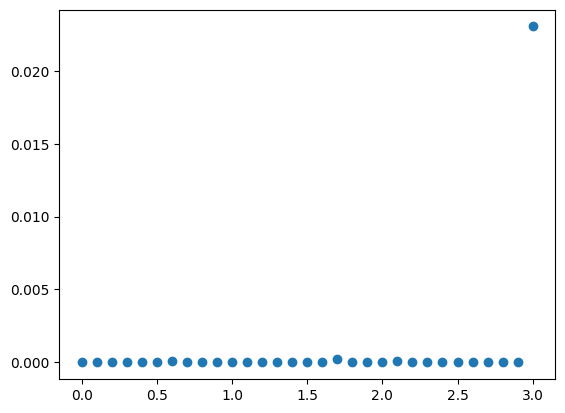

In [74]:
plt.scatter(np.array(mags)[:,0], np.array(mags)[:,1])

In [59]:
N = 8
obs = sum(nk.operator.spin.sigmaz(hilbert, i) for i in range(N))
vstate.expect(obs)

ValueError: An operator acts on an invalid set of sites.

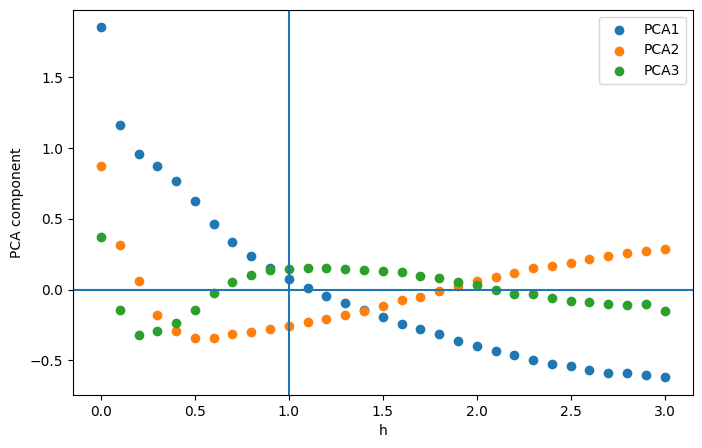

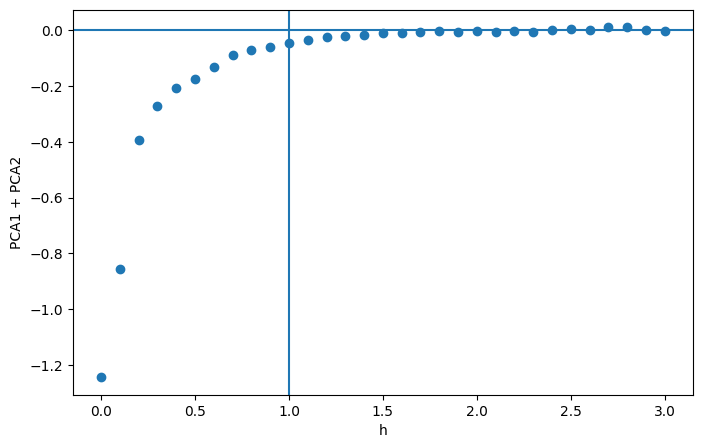

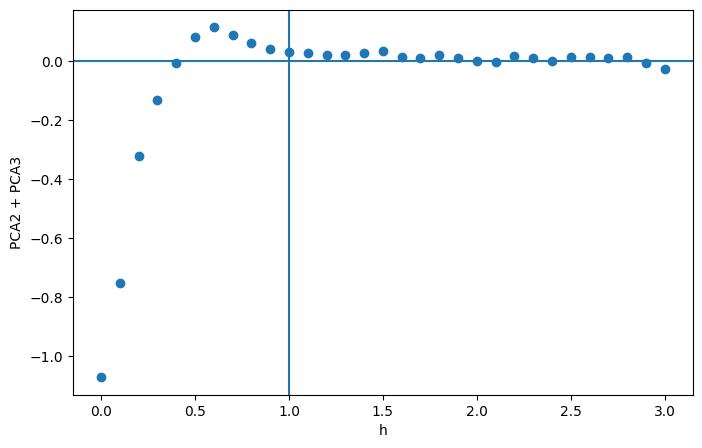

In [26]:
dh = 0.1

# build an hs array
hs = np.arange(0., 3.0+1e-10, dh)
h_baseline = 0
params = []
for h_i in hs: 
    h_i = h_i.item()
        
    with open(os.path.join('../experiments/results', f'{0}', 'finetune', f'baseline_h{h_baseline:.3f}', f'results_h{h_i:.3f}.json'),  'r') as file:
        results = json.load(file)
        params.append(results['params'])

pca = KernelPCA(n_components = 3)
X = pca.fit_transform(params)
plt.figure(figsize = (8,5))
# scatter = plt.scatter(X[:, 0], X[:, 1], c=all_hs)
plt.scatter(hs, X[:,0], label = 'PCA1')
plt.scatter(hs, X[:,1], label = 'PCA2')
plt.scatter(hs, X[:,2], label = 'PCA3')
#plt.scatter(hs, X[:,1])
plt.legend()
plt.axhline(0)
plt.axvline(1)
plt.xlabel('h')
plt.ylabel('PCA component')
plt.show()
plt.close()

plt.figure(figsize = (8,5))
plt.scatter(hs, np.gradient(X[:,1]) + np.gradient(X[:,0]))
plt.xlabel('h')
plt.ylabel('PCA1 + PCA2')
#plt.scatter(hs, X[:,1])
plt.axhline(0)
plt.axvline(1)
plt.show()
plt.close()

plt.figure(figsize = (8,5))
plt.scatter(hs, np.gradient(X[:,2]) + np.gradient(X[:,1]))
plt.xlabel('h')
plt.ylabel('PCA2 + PCA3')
#plt.scatter(hs, X[:,1])
plt.axhline(0)
plt.axvline(1)
plt.show()
plt.close()

In [45]:
import os
import json

def load_results(results_dir):
    """Loads results from a directory."""
    results_path = os.path.join(results_dir, 'results.json')
    
    if os.path.exists(results_path):
        with open(results_path, 'r') as file:
            results = json.load(file)
        return results
    else:
        raise FileNotFoundError(f"Results file not found in {results_dir}")
index = 0
script_dir = '../experiments'
results_base_dir = os.path.join(script_dir, 'results2', str(index))
baseline_dir = os.path.join(results_base_dir, 'baselines')
results = load_results(baseline_dir)
print(results)

{'infidelity': 7.37188088351104e-14, 'wavefunc': [0.10878384277265207, 0.16666672899313456, 0.2553481980995007, 0.14656412425453344, 0.25534821051233797, 0.4798975056141905, 0.22454933660505288, 0.1666667427258335, 0.1666667427258335, 0.22454933660505288, 0.4798975056141905, 0.25534821051233797, 0.14656412425453344, 0.2553481980995007, 0.16666672899313456, 0.10878384277265207], 'wavefunc_exact': [0.10878394077768988, 0.16666666666666657, 0.25534814770632597, 0.1465642069286362, 0.255348147706326, 0.4798975402619697, 0.22454939255564332, 0.16666666666666657, 0.16666666666666666, 0.2245493925556432, 0.4798975402619696, 0.2553481477063259, 0.1465642069286361, 0.2553481477063261, 0.16666666666666677, 0.10878394077768991], 'energy': [-3.9998711357916665, -4.005975481207938, -4.01572214229752, -4.032134654704398, -4.0564211588529036, -4.089141456518183, -4.130693675516514, -4.181050648197866, -4.239439087363737, -4.304187079060901, -4.372751588321903, -4.4419664359727005, -4.508436837753304,

In [46]:
import flax

def load_vstate(path, vstate):
    """Loads a variational state from disk."""
    with open(path, 'rb') as file:
        return flax.serialization.from_bytes(vstate, file.read())

In [48]:
h_i = 0.0
vstate_path = os.path.join(baseline_dir, f'vstate_h{h_i:.3f}.mpack')
vstate = load_vstate(vstate_path, vstate)

In [50]:
vstate.parameters

{'RBM_0': {'Dense': {'bias': Array([-0.38207126,  0.40779161, -0.41623894,  0.42056905, -0.3811287 ,
          -0.39161107, -0.41275087,  0.41997281], dtype=float64),
   'kernel': Array([[-0.46643844,  0.37289474, -0.37999624,  0.42543302, -0.37838229,
           -0.36443631, -0.36770877,  0.38726088],
          [ 0.38642391, -0.40904848,  0.41400362, -0.35666168,  0.34403492,
            0.34970865,  0.35790957, -0.38172538],
          [-0.37553176,  0.36413723, -0.35049946,  0.36615221, -0.43528423,
           -0.39556185, -0.358474  ,  0.35531924],
          [ 0.38374186, -0.39017564,  0.37495799, -0.36419444,  0.40358814,
            0.4200732 ,  0.39504865, -0.35953055]], dtype=float64)},
  'visible_bias': Array([ 0.37017275, -0.34759205,  0.36455321, -0.35832869], dtype=float64)}}

In [115]:
dh = 0.025

# build an hs array
hs = np.arange(0., 3.0+1e-10, dh)
hs.shape

(121,)

In [32]:
vstate.parameters

dict

In [ ]:
dh = 0.025

# build an hs array
hs = np.arange(0., 3.0+1e-10, dh)
hs.shape

(121,)

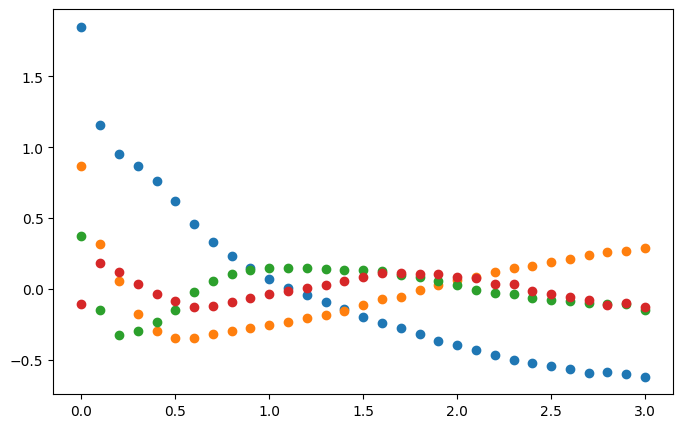

In [124]:
pca = KernelPCA(n_components = 4)
X = pca.fit_transform(params)
plt.figure(figsize = (8,5))
# scatter = plt.scatter(X[:, 0], X[:, 1], c=all_hs)
plt.scatter(hs, X[:,0])
plt.scatter(hs, X[:,1])
plt.scatter(hs, X[:,2])
plt.scatter(hs, X[:,3])

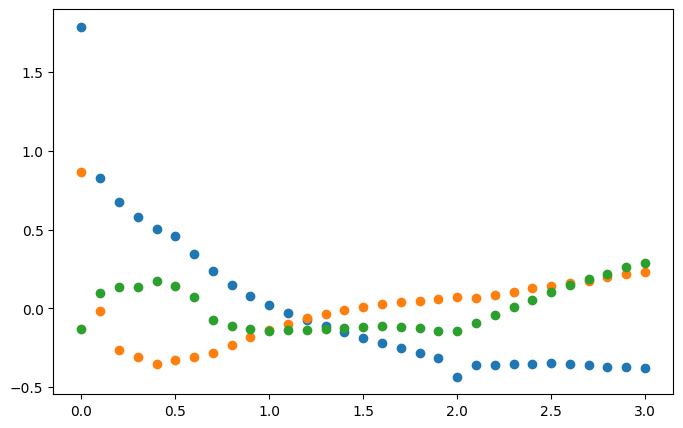

In [101]:
pca = KernelPCA(n_components = 3)
X = pca.fit_transform(params)
plt.figure(figsize = (8,5))
# scatter = plt.scatter(X[:, 0], X[:, 1], c=all_hs)
plt.scatter(hs, X[:,0])
plt.scatter(hs, X[:,1])
plt.scatter(hs, X[:,2])

In [57]:
dhs = [0.025, 0.05, 0.1, 0.2]
for dh in dhs:
    shape = np.arange(0,3.001,dh).shape[0]
    print(shape, shape//3)


121 40
61 20
31 10
16 5


In [58]:
dh = 0.1
shape = np.arange(0,3.001,dh).shape[0]
print(shape, shape//3)
for i in range(shape//3):
    print(i/(shape//3))
    results[sorted(all_hs)[i].item()]['color'] = plt.cm.Blues_r(i/(shape//3))
for i in range(shape - shape//3):
    print(i/(shape - (shape//3)))
    results[sorted(all_hs)[i+shape//3].item()]['color'] = plt.cm.Reds(i/(shape - (shape//3)))

31 10
0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
0.0
0.047619047619047616
0.09523809523809523
0.14285714285714285
0.19047619047619047
0.23809523809523808
0.2857142857142857
0.3333333333333333
0.38095238095238093
0.42857142857142855
0.47619047619047616
0.5238095238095238
0.5714285714285714
0.6190476190476191
0.6666666666666666
0.7142857142857143
0.7619047619047619
0.8095238095238095
0.8571428571428571
0.9047619047619048
0.9523809523809523


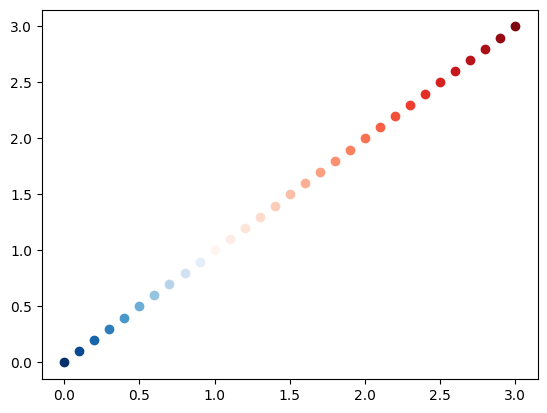

In [59]:
for h_i in sorted(all_hs):
    plt.scatter(h_i.item(), h_i.item(), color = results[h_i.item()]['color'])

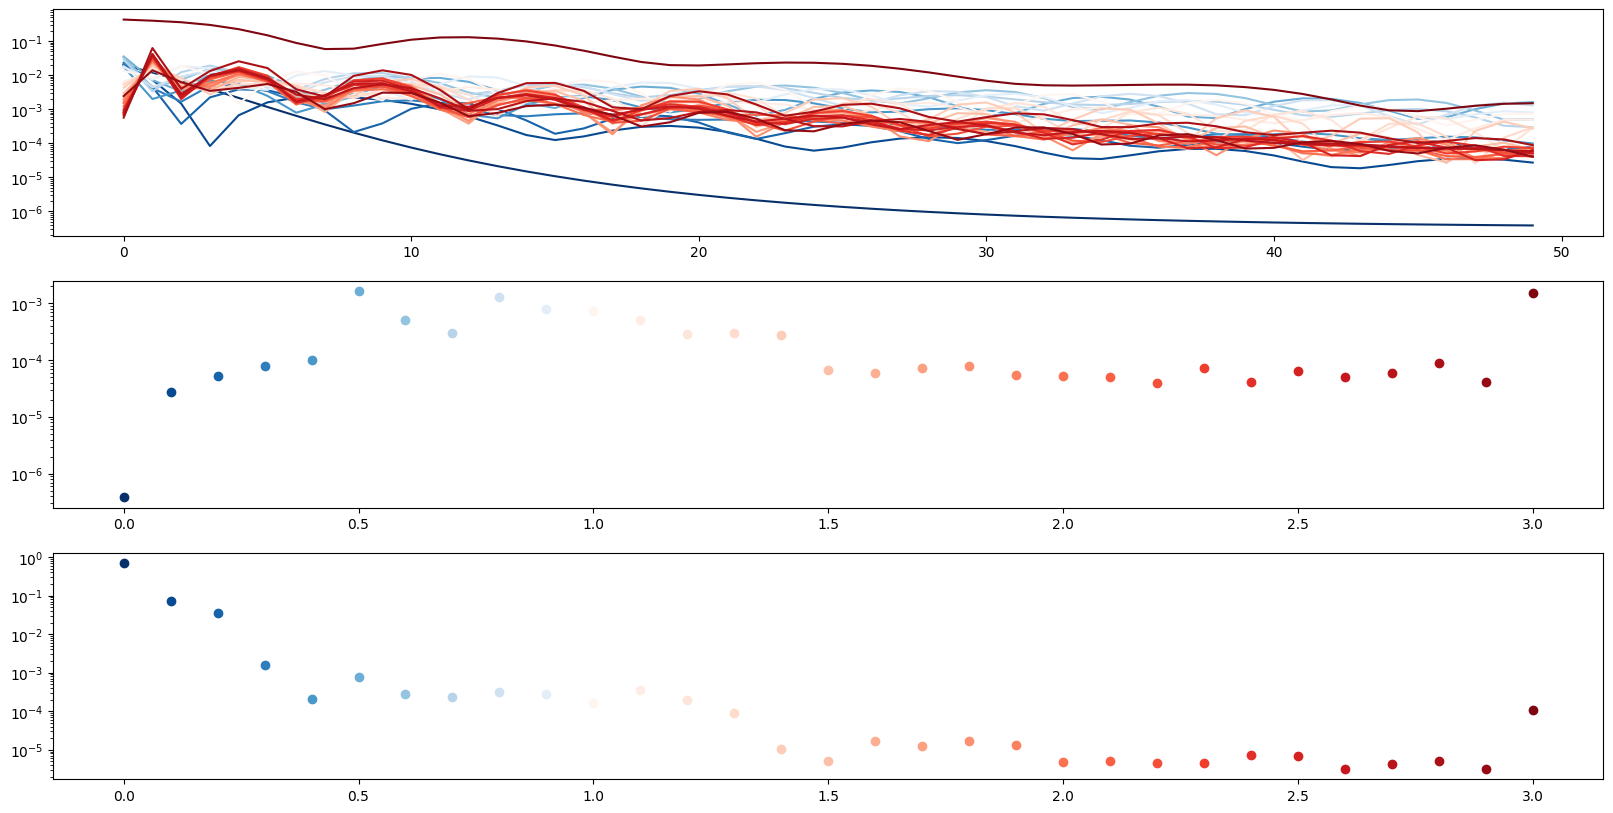

In [60]:

fig, ax = plt.subplots(3,1, figsize = (20,10))

for i in range(len(all_hs)):
    h_i = sorted(all_hs)[i].item()
    energy_error = np.absolute(np.abs(results[h_i]['energy']) - np.abs(results[h_i]['energy_exact']))
    ax[0].plot(energy_error, color = results[h_i]['color'])
    ax[1].scatter(h_i, energy_error[-1], color = results[h_i]['color'])
    ax[2].scatter(h_i, results[h_i]['infidelity'], color = results[h_i]['color'])
    for i in range(3):
        ax[i].set_yscale('log')


In [65]:
a = {}
b = a.copy()
a['a'] = {}
c = a['a'].copy()

In [ ]:
os.path.join(script_dir, 'results', 'baselines', f'results_{index}_h{h_i}.json')

In [50]:
energies_exact_all_h[i]

NameError: name 'energies_exact_all_h' is not defined

In [127]:
energies = np.array(energies_all_h)
energies[:,-1]

array([-4.64420912, -5.01329992, -5.074937  , -5.17475284, -5.32030264,
       -5.5146765 , -5.76436676, -6.07237996, -6.43550232, -6.84603763,
       -7.2942566 ])

In [128]:
acts_h = jnp.array(activations_all_h).reshape(len(activations_all_h), -1)

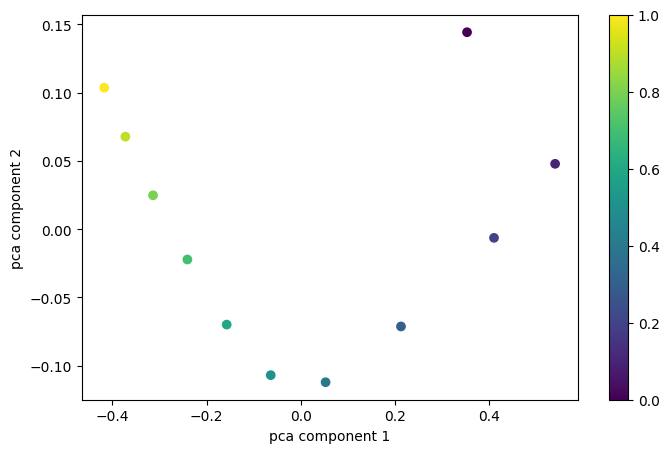

In [129]:
pca = KernelPCA(n_components = 3)
X = pca.fit_transform(params_all_h)
plt.figure(figsize = (8,5))
scatter = plt.scatter(X[:, 0], X[:, 1], c=all_hs)
plt.colorbar(scatter)
plt.xlabel('pca component 1')
plt.ylabel('pca component 2')
plt.show()

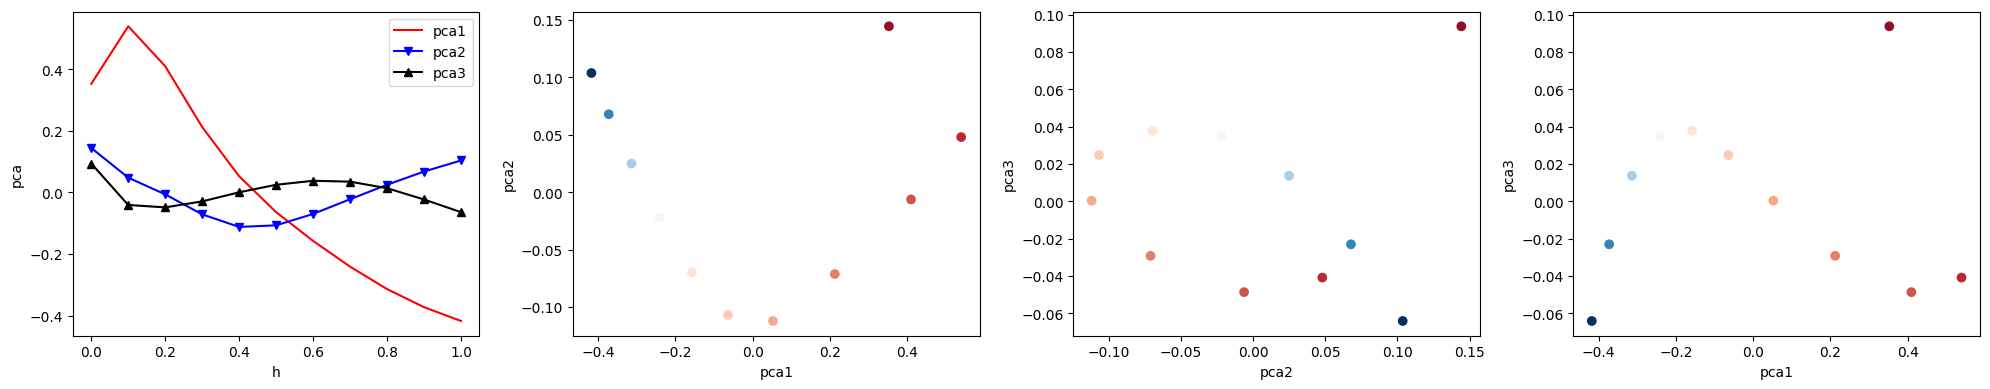

In [130]:
fig, ax = plt.subplots(1,4, figsize = (20,4))
ax[0].plot(all_hs, X[:,0], c='red', label = 'pca1')
ax[0].plot(all_hs, X[:,1], c='blue', marker = 'v', label = 'pca2')
ax[0].plot(all_hs, X[:,2], c='k', marker = '^', label = 'pca3')
#ax[0].plot(all_hs, magnetizations)
ax[0].legend()
ax[0].set_xlabel('h')
ax[0].set_ylabel('pca')
ax[1].scatter(X[:, 0], X[:, 1], c=color_h)
ax[1].set_xlabel('pca1')
ax[1].set_ylabel('pca2')
ax[2].scatter(X[:, 1], X[:, 2], c=color_h)
ax[2].set_xlabel('pca2')
ax[2].set_ylabel('pca3')
ax[3].scatter(X[:, 0], X[:, 2], c=color_h)
ax[3].set_xlabel('pca1')
ax[3].set_ylabel('pca3')
plt.tight_layout()
plt.show()

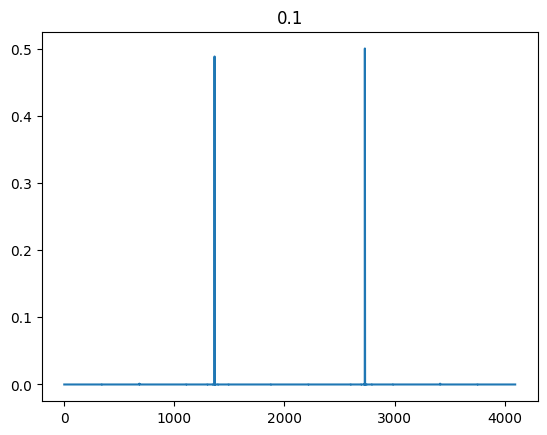

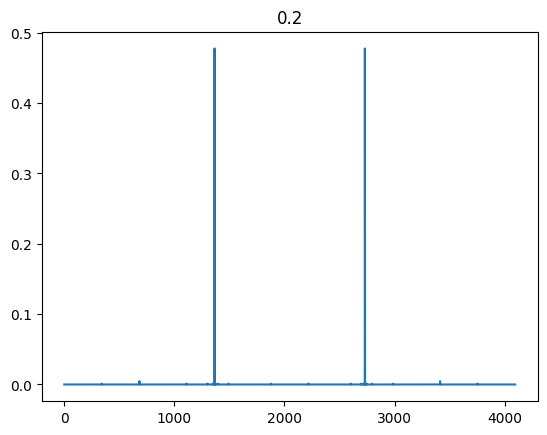

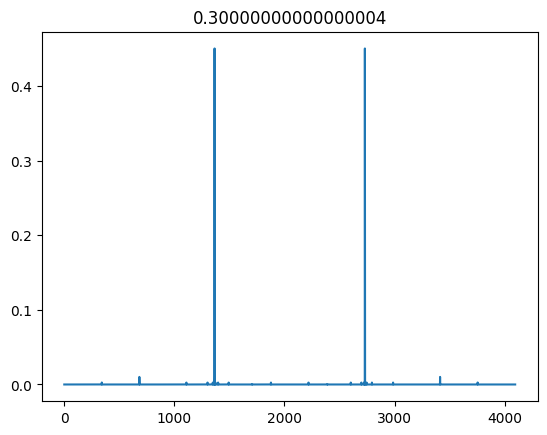

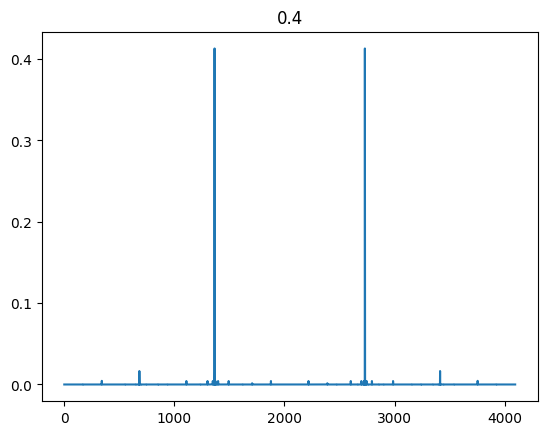

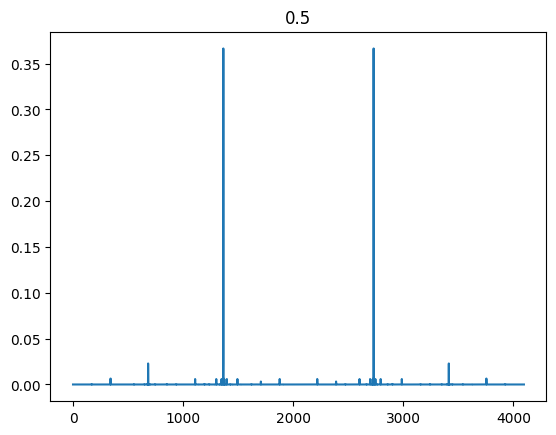

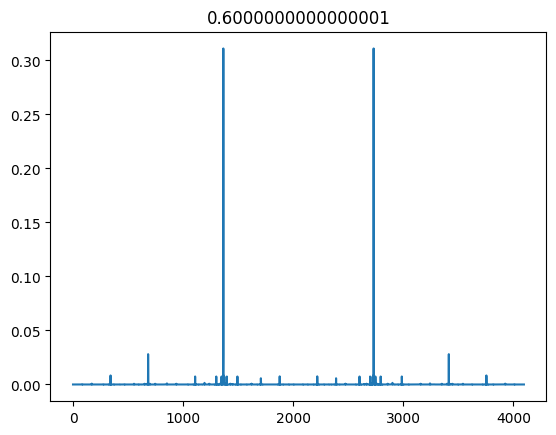

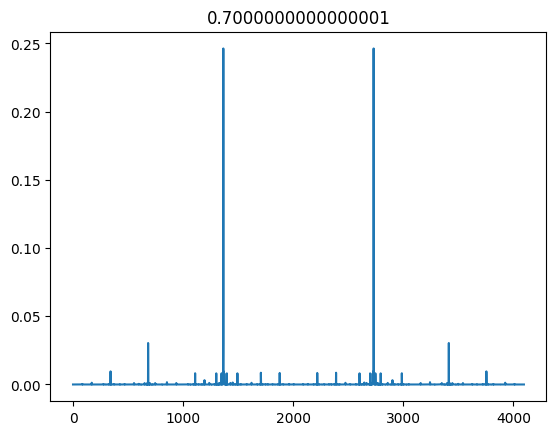

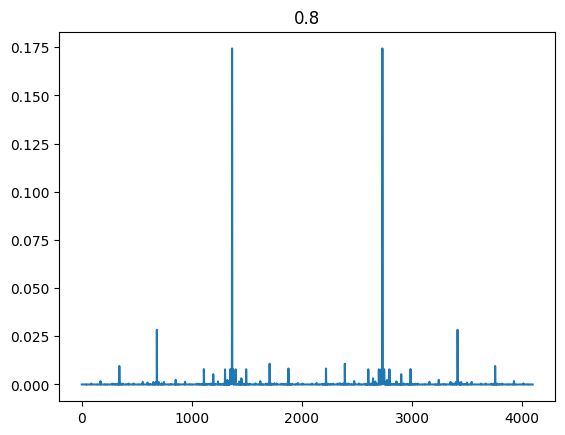

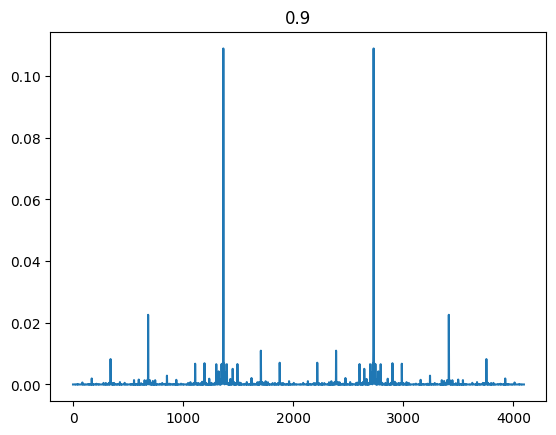

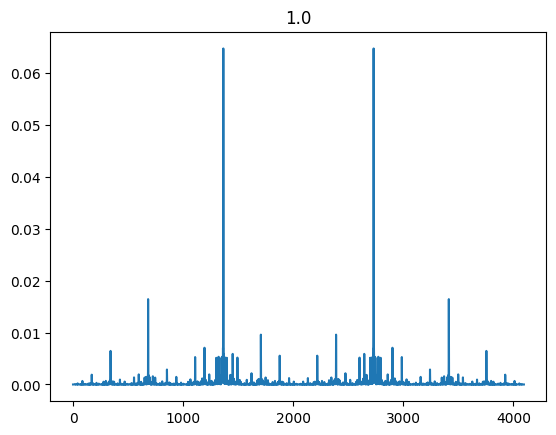

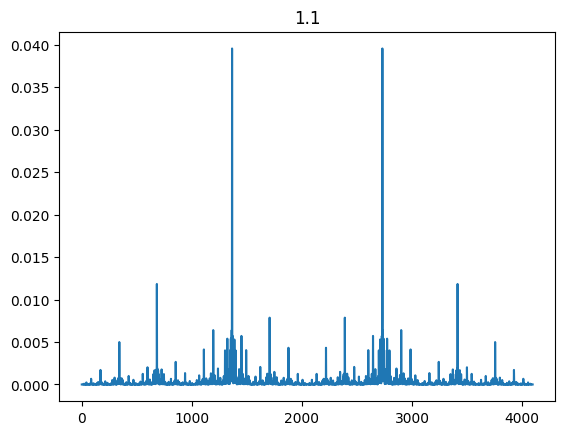

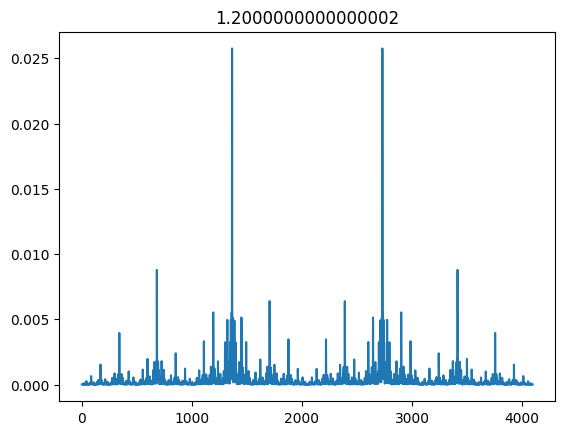

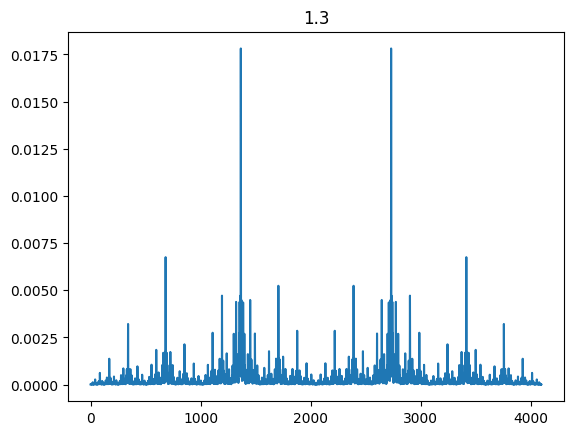

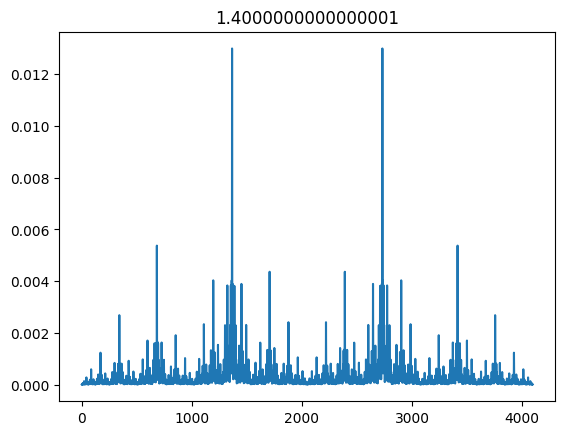

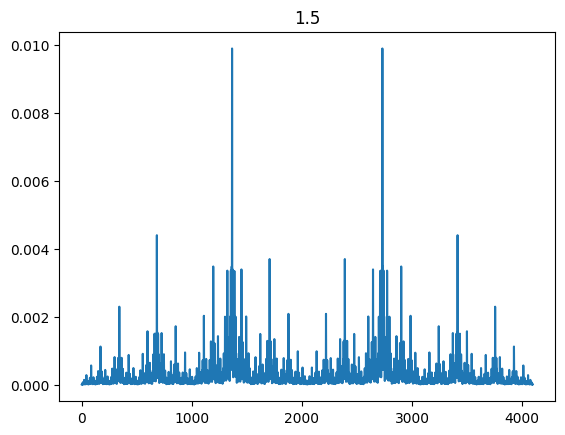

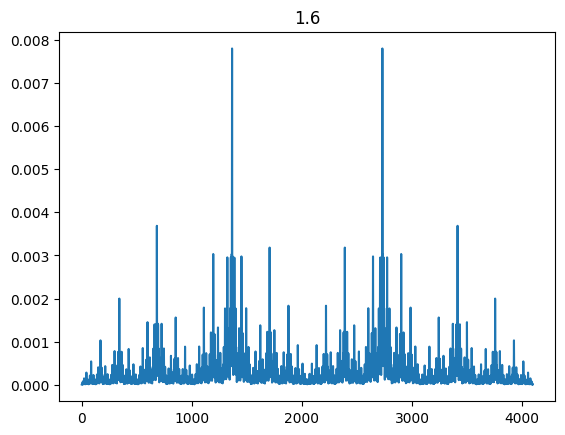

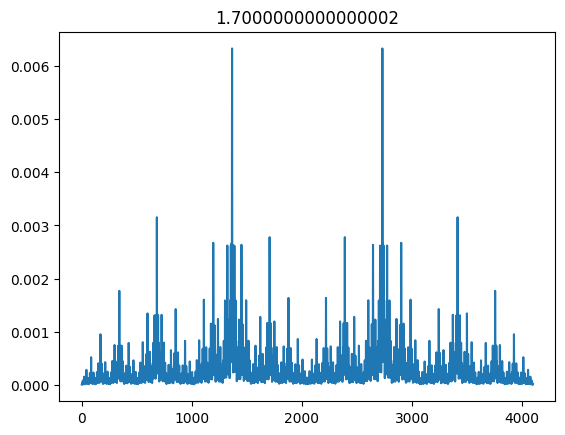

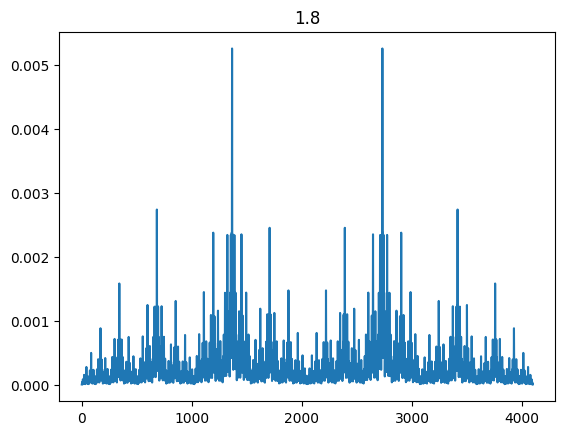

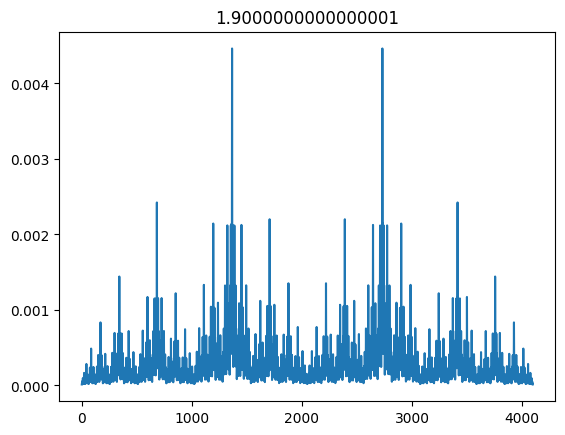

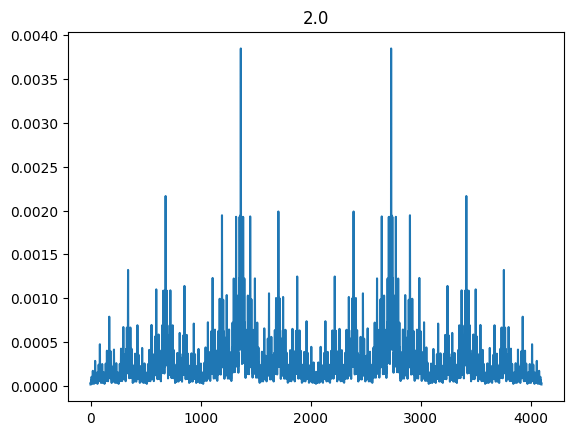

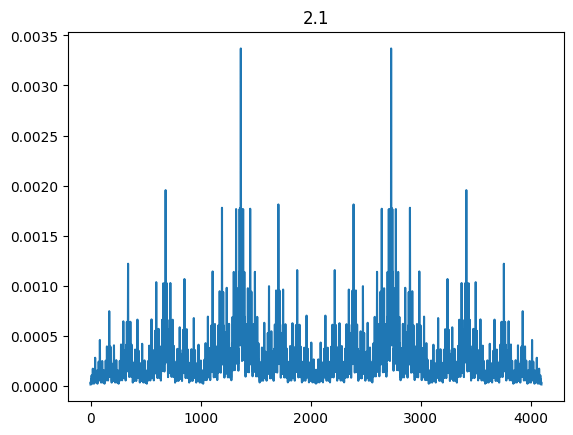

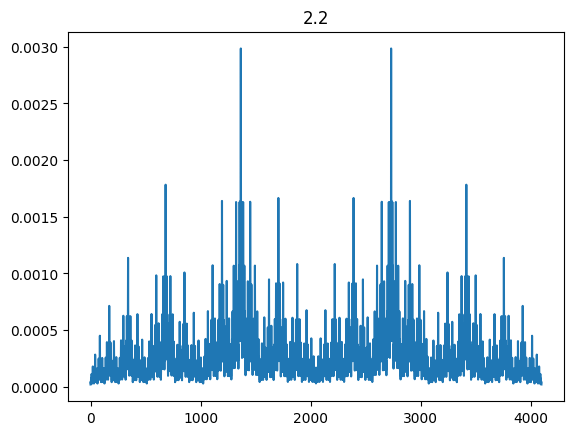

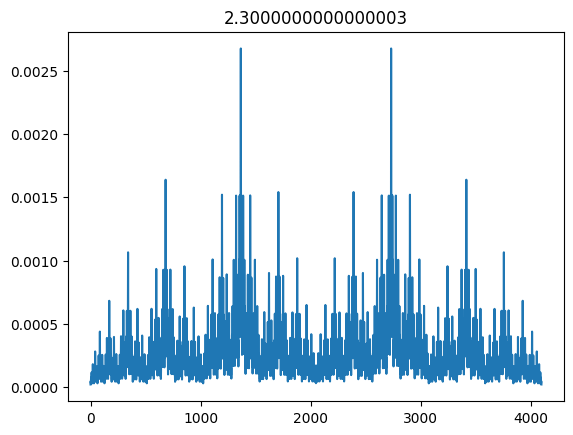

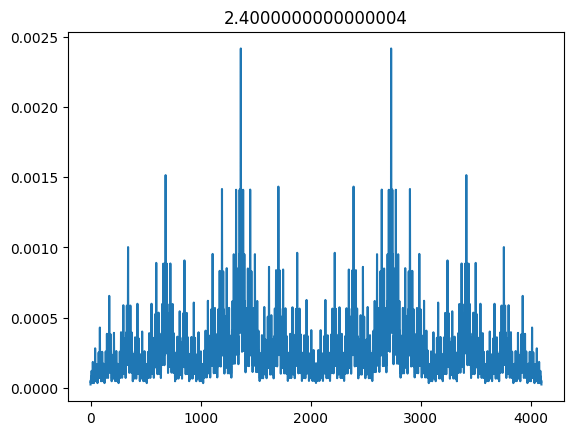

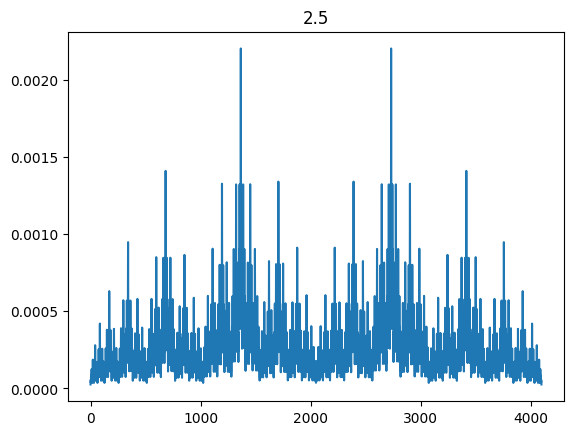

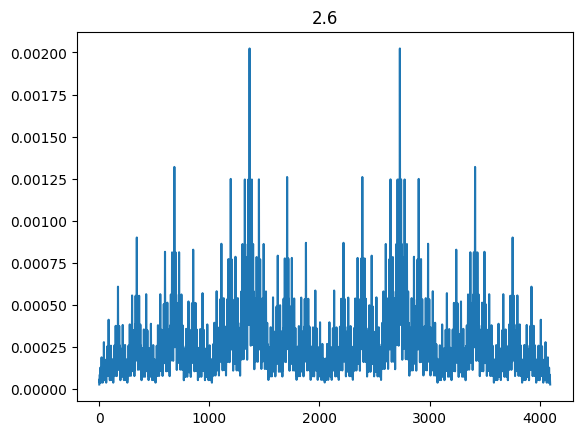

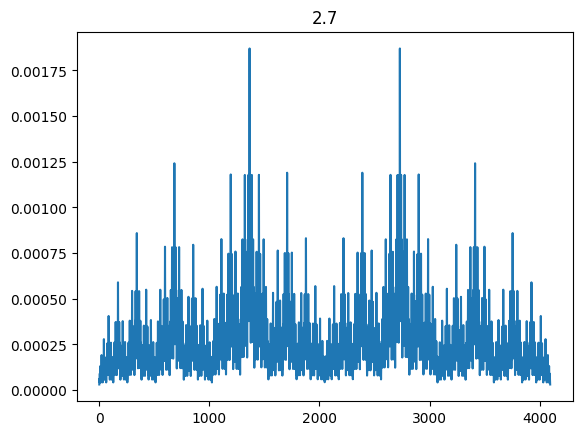

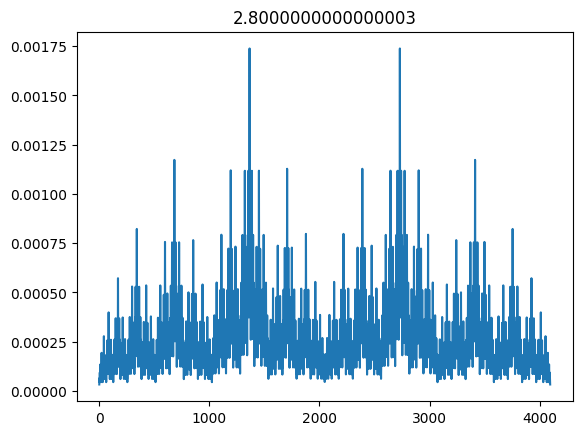

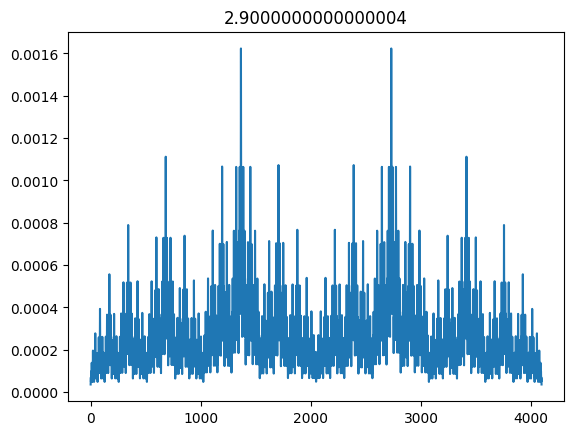

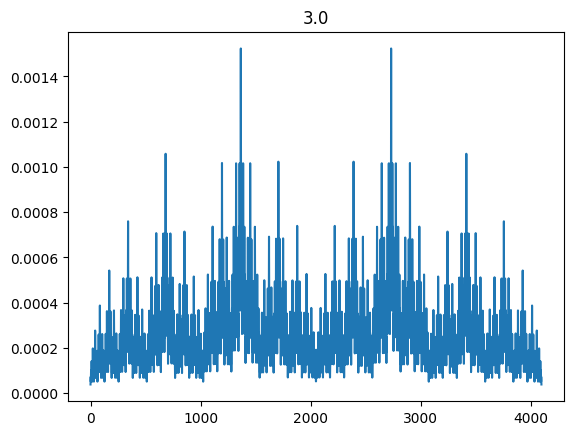

In [56]:
for i, wf in enumerate(exact_wavefuncs_all_h):
    plt.plot(np.abs(wf)**2)
    plt.title(all_hs[i])
    plt.show()
    plt.close()

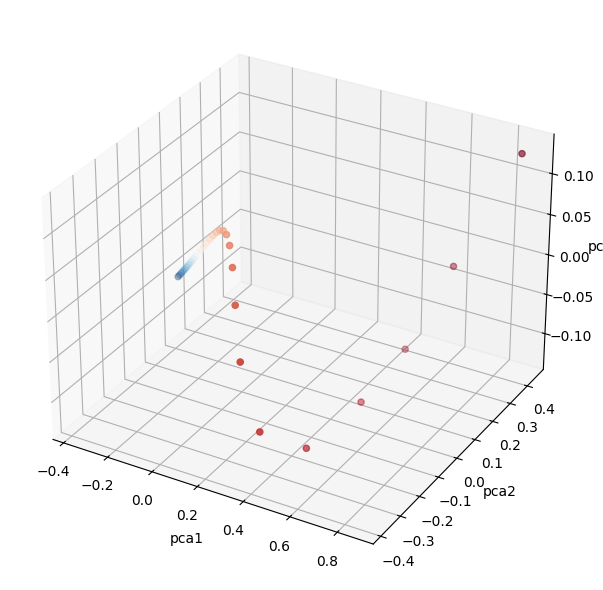

In [30]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color_h, marker='o')
ax.set_xlabel('pca1')
ax.set_ylabel('pca2')
ax.set_zlabel('pca3')
plt.tight_layout()
plt.show()

In [31]:
activations_all_h = jnp.array(activations_all_h)

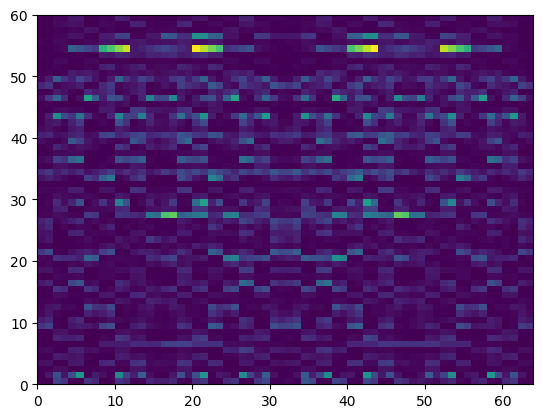

In [32]:
# fig, ax = plt.subplots(16, figsize = (10,20))

# for i in range(16):
#     ax[i].pcolormesh(activations_all_h[:,0:2,i].T)
#     ax[i].axis('off')
# plt.show()


plt.pcolormesh(activations_all_h[-1].T)
plt.show()

In [244]:
for i, h_i in enumerate(all_hs):
    plt.figure(figsize = (20,5))
    plt.pcolormesh(activations_all_h[i][:128].T)
    plt.xlabel('spin configuration')
    plt.ylabel('neuron index')
    plt.title(f'activations for h = {h_i:.3f}')
    plt.savefig(f'figs/activations/h{h_i:.3f}_v2.jpg')
    plt.close()

In [245]:
figs = []
for h_i in all_hs:
    figs.append(Image.open(f'figs/activations/h{h_i:.3f}_v2.jpg'))

figs[0].save('figs/activations/activations_gif_all_h.gif',
             save_all = True,
             append_images = figs[1:],
             duration = 100,
             loop = 0)

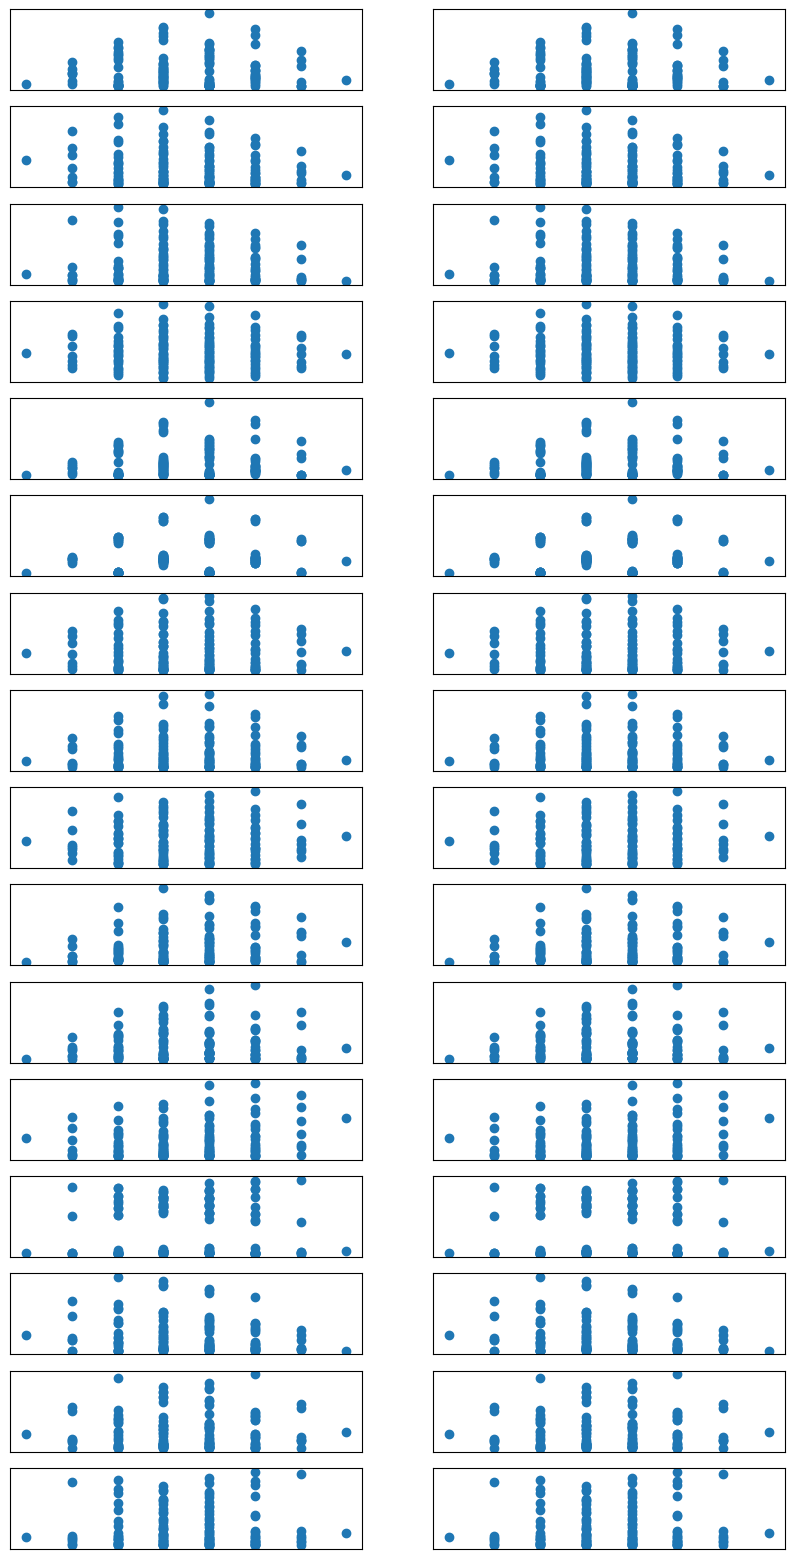

In [254]:
fig, ax = plt.subplots(16,2, figsize = (10,20))
for i in range(16):
    ax[i,0].scatter(hilbert.all_states()[:128].sum(1), activations_all_h[-1,:,i][:128])
    ax[i,1].scatter(np.count_nonzero(hilbert.all_states()[:128] == 1, axis = 1), activations_all_h[-1,:,i][:128])
    for j in range(2):
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
plt.show()
plt.close()

In [249]:
np.count_nonzero(hilbert.all_states()[:128] == 1, axis = 1)

array([0, 1, 1, 2, 1, 2, 2, 3, 1, 2, 2, 3, 2, 3, 3, 4, 1, 2, 2, 3, 2, 3,
       3, 4, 2, 3, 3, 4, 3, 4, 4, 5, 1, 2, 2, 3, 2, 3, 3, 4, 2, 3, 3, 4,
       3, 4, 4, 5, 2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6, 1, 2,
       2, 3, 2, 3, 3, 4, 2, 3, 3, 4, 3, 4, 4, 5, 2, 3, 3, 4, 3, 4, 4, 5,
       3, 4, 4, 5, 4, 5, 5, 6, 2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5,
       5, 6, 3, 4, 4, 5, 4, 5, 5, 6, 4, 5, 5, 6, 5, 6, 6, 7])

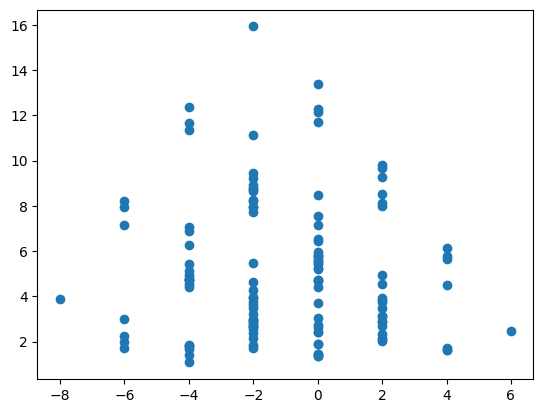

In [219]:
plt.scatter(hilbert.all_states()[:128].sum(1), activations_all_h[-1,:,:][:128].sum(1))

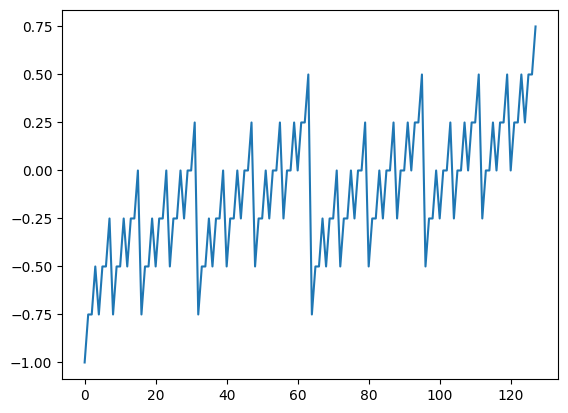

In [221]:
plt.plot(magnetizations[:128])